In [1]:
'''Loading libraries'''
import pandas as pd 
import numpy as np 
from scipy.stats import gamma, dirichlet, beta, nbinom, norm
import time
import matplotlib.pyplot as plt


'''
Notes: 
1) Likelihood_F I had to add a constant to avoid log(0). Check for a better solution
2) Proposed values aren't good, all values are rejected 
3) Check likelihood_P
4) Priori too much weight? 
5) Add track of accetance rate
6) Proposal values too bad
7) Track running time
8) create a function to save files/images with a labeled name 
9) track the other variables I might want to manual change to test acceptance and convergence
10) Rewrite the priori and likelihood removing the distributions and using the equations, cutting what
i don't need. I think using like I'm using won't converge. 
11) Use c++ if compute canada is not a hand option or convergence problems. 
'''


'''Important parameters I need to constantly change'''
k = 100
sim = 1000
start_time = time.time()


In [2]:
'''Loading dataset'''
#filename = "C:\\Users\\raoki\\Documents\\GitHub\\project_spring2019\\Data\\data_final.csv"
filename = "C:\\Users\\raque\\Google Drive\\SFU\\Project 2 - Spring 2019\\Data\\data_final.csv"
#filename = "C:\\Users\\raque\\Google Drive\\SFU\\Project 2 - Spring 2019\\Data\\data_final_sub.csv"
data = pd.read_csv(filename, sep=',')


In [3]:
'''Saving time in the first part'''
data = data.iloc[0:500, 0:300]
data.shape

(500, 300)

In [4]:
'''Organizing columns names'''
lr = data.columns[[2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]
y = data.columns[3]
remove = data.columns[[0,1]]
data_complete = data.copy()

In [5]:
'''
Class to work with model parameters
I thought about using the default values as chain starting values, 
however, i encouter problems to change the size of arrays and matrices 
according with my currently k
'''
class parameters:
    def __init__(self, latent_v,latent_sk,latent_pj,latent_phi ,latent_tht, prediction):
        self.ln = latent_v #array with parameters that are only one number [0-c0,1-gamma0,2-eta,3-cj] 
        self.la_sk = latent_sk #array 
        self.la_pj = latent_pj #array
        self.lm_phi = latent_phi #matrix (jk)
        self.lm_tht = latent_tht #matrix  (kv)      
        self.p = prediction #array [intercept, gender, 15 cancer types, k genes]


In [6]:
'''
Declaring my priori values: param.ln = [0-c0,1-gamma0,2-eta,3-cj], param.la_sk, param.la_pj, 
param.lm_phi, param.lm_tht and param.p = [] 
#j=sample of patients 
#v=genes
#k=latent
#UPDATE PARAM 
'''
def priori_l(param):
    k = len(param.la_sk)
    j = len(param.la_pj)
    v = param.lm_phi.shape[0]
    #Prioris on the K plate
    s0 = 2.4 
    t0 = 2.4 
    c0 = gamma.pdf(x=param.ln[0],a = s0,scale = t0) #mean 6
    a0 = 2.4 
    b0 = 2.4 
    gamma0 = gamma.pdf(x=param.ln[1],a = a0,scale = b0) #mean 6
    sk = gamma.pdf(x=param.la_sk,a=param.ln[1],scale=param.ln[0])#array(k)  mean is 40
    s0 = 1
    w0 = 1
    eta = gamma.pdf(x=param.ln[2], a = s0, scale = w0) #CHECH HERE AGAIN
    phivk = dirichlet.pdf(x=param.lm_phi, alpha=np.repeat(param.ln[2],v)) #MATRIX #1
    priorik = np.log(c0)+np.log(gamma0)+np.log(sk).sum()+np.log(eta)+np.log(phivk).sum()
    #priories on the J plate
    a0 = 2 
    b0 = 2 
    pj = beta.pdf(x=param.la_pj,a=a0,b=b0)  #beta(2,2) is symetric and centred in 0.5
    e0 = 6.4
    f0 = 6.4
    cj = gamma.pdf(param.ln[3], a = e0, scale = f0) #mean is 40
    priorij = np.log(pj).sum()+np.log(cj) #array    
    #prioris on K and J plate
    thetakj = gamma.pdf(x=np.transpose(param.lm_tht),a=param.la_sk.reshape(1,k),scale = param.ln[3]) #MATRIX 
    priorikj = np.log(thetakj).sum()
    return (priorik+priorij+priorikj)
  
#increase the sd to decrease the .sum()//increase uncertainity about parameters    
def priori_p(param):
    '''
    #add prioris of logistic regression 
    #features are the theta_kj parameters and clinical info
    #one parameter for each latent variable + one parameter for each clinical features
    '''
    k = len(param.la_sk)
    mean = [-len(param.p),1] #intercept and gender
    sd = [10,5]
    mean.extend(np.repeat(1/15, 15))
    sd.extend(np.repeat(3,15))
    mean.extend(np.repeat(1,k))
    sd.extend(np.repeat(5,k))
    lr = norm.pdf(param.p,loc = mean, scale = sd) #loc/mean, scale/sd
    return (np.log(lr).sum()) 

In [7]:
'''
Declare all the likelihood distributions in two separete functions
#_F represents the factor model likelihood and _P the prediction model likelihood
'''

#PASS DATA ONLY WITH RELEVANT COLUMNS FOR THIS PROBLEM 
def likelihood_F(param,dataf):
    '''phi(jk) x theta(kv) must be matrix , final dim is j patients x v genes '''
    phi_theta = np.dot(param.lm_phi, param.lm_tht)
    phi_theta = np.transpose(phi_theta)
    la_pj = np.repeat(param.la_pj, dataf.shape[1]).reshape(param.la_pj.shape[0],dataf.shape[1])
    nvj = nbinom.pmf(dataf,n = phi_theta,p= la_pj) #matrix and array?
    nvj += 0.000001  #LOOK FOR BETTER SOLUTION 
    return np.log(nvj).sum()


def likelihood_P(param, datap,y):
    '''[intercept, gender, 15 cancer types, k genes]'''
    xw = param.p[0]
    for i in np.arange(1,datap.shape[1]):
        xw = xw+param.p[i]*datap[datap.columns[i-1]]
    
    theta = np.transpose(param.lm_tht)
    aux = datap.shape[1]

    for j in np.arange(0,theta.shape[1]):
        xw = xw + param.p[aux+j]*theta[:,j]
    
    xwy = 0
    for k in np.arange(1,len(y)): 
        xwy = xwy+xw[k]*y[k]
    
    lxp = sum(-np.log(1+np.exp(xw)))
    #page 2 http://www.medicine.mcgill.ca/epidemiology/joseph/courses/EPIB-621/bayeslogit.pdf
    #http://www.utstat.utoronto.ca/reid/sta2201s/2014/feb14-annotated-copy.pdf
    #https://www.statlect.com/fundamentals-of-statistics/logistic-model-maximum-likelihood
    return xwy + lxp

In [8]:
'''
Definition of the posterior distribution and the split of the datasets
Note: the parameters are ok 
'''
def posterior(param,data_F,data_P,y,k):
    j = data.shape[0]
    lf = likelihood_F(param,data_F)
    lp = likelihood_P(param, data_P,y)
    pl = priori_l(param)
    pp = priori_p(param)
    #print(lf,lp,pl,pp)
    return (lf+lp+pl+pp)

In [9]:
'''
Proposal distribution
'''

#Proposal values for the parameters related to the factor model 
#Repete the parameters related to prediction and only propose
#new values for the factor analysys part
#output is the parameters class 
def proposal_f(current):
    new = parameters(np.random.normal(current.ln,0.0005),
                     np.random.normal(current.la_sk,0.0005),
                     np.random.beta(current.la_pj/2,current.la_pj/2),
                     np.random.normal(current.lm_phi,0.0005),
                     np.random.normal(current.lm_tht,0.005), 
                     current.p)
    new.lm_phi[new.lm_phi<0] = 0.00001
    col_sums = new.lm_phi.sum(axis=0)
    new.lm_phi = new.lm_phi / col_sums[np.newaxis,:]
    return new

#Proposal values for the parameters related to logistic regression 
#Repete the parameters related to factor analysis part and propose
#new values for the logistc regression parameters 
#output is the parameters class 
def proposal_p(current):
    new = parameters(current.ln, current.la_sk, current.la_pj, 
                     current.lm_phi, current.lm_tht, 
                     np.random.normal(current.p,0.05))
    return new

In [10]:
'''
Creatint the MCMC for the model
MCMC(
startvalue = initial value for the parameters
iterations = 
data = complete data with all columns 
k = number of latent variables
remove, lr, y = columns names to be removed, presente only in the logistic regression part and y
)
'''
def MCMC(startvalue, iterations, data,k, lr,y):
    '''Splitting dataset'''
    data_P = data[lr]
    data_F = data.drop(lr,axis = 1)
    data_F = data_F.drop(y,axis = 1)
    y = data[y]
    a_P = 0
    a_F = 0
    '''
    Initialization of the chains
    Note: chain_f has elements from chain_p and vice-versa. Take care to not use incorrectly
    '''     
    chain_f = []
    chain_p = []
    chain_f.append(startvalue)
    chain_p.append(startvalue)
     
    for i in np.arange(1,iterations):
        '''Factor Analysis - Latent Features'''
        #use chain_f or chain_p don't make difference here because
        #the only parameters changed are the logistic regression and 
        #they aren't used in the factor analysis part. 
        param_new_f = proposal_f(chain_f[i-1])
        param_cur_f = chain_f[i-1] 
        if i%100 == 0: 
            print('iteration ',i,' acceptance ', a_F*100/i,'-', a_P*100/i)
        prob_f = np.exp(posterior(param_new_f,data_F,data_P,y,k)-posterior(param_cur_f,data_F,data_P,y,k))
        if np.random.uniform(0,1,1)<prob_f:
            chain_f.append(param_new_f)
            a_F+=1
        else:
            chain_f.append(param_cur_f) 
        '''Logistic Regression - Prediction'''
        #chain_f[i] has the most update latent parameters and haven't changed the 
        #prediction parameters from [i-1] iteration
        param_new_p = proposal_p(chain_f[i-1])
        param_cur_p = chain_f[i-1]
    
        prob_p = np.exp(posterior(param_new_p,data_F,data_P,y,k)-posterior(param_cur_p,data_F,data_P,y,k))
        if np.random.uniform(0,1,1)<prob_p:
            chain_p.append(param_new_p)
            a_P+=1
        else:
            chain_p.append(param_cur_p)     

    return chain_p, chain_f, a_P, a_F
        
        

In [11]:
'''Non informative prioris: dirichlet has only 1, gamma distribution with 1 average, etc'''
aux = len(lr)+1
data = data.drop(remove,axis = 1)

start = parameters([3,6,2,41], #ln 
                   np.repeat(15,k), #la_sk
                   np.repeat(0.5,data.shape[0]), #la_pj
                   np.repeat(1/(data.shape[1]-aux),(data.shape[1]-aux)*k).reshape((data.shape[1]-aux),k) ,#lm_phi v x k 
                   np.repeat(1600,(data.shape[0])*k).reshape(k,(data.shape[0])), #lm_theta k x j
                   np.concatenate(([-(k+aux)], np.repeat(1,k+aux-1))))  #p, k+aux-1  because intercept is already counted



In [12]:
#data = data.drop(remove,axis=1)

start_time = time.time()
output_p, output_f, acept_P,acept_F = MCMC(start,sim,data,k,lr,y)
end_time = time.time() - start_time

print("--- %s seconds ---" % (time.time() - start_time))



C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less
C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\raque\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less


iteration  100  acceptance  0.0 - 0.0
iteration  200  acceptance  0.0 - 0.0
iteration  300  acceptance  0.0 - 0.0
iteration  400  acceptance  0.0 - 0.0
iteration  500  acceptance  0.0 - 0.0
iteration  600  acceptance  0.0 - 0.0
iteration  700  acceptance  0.0 - 0.0
iteration  800  acceptance  0.0 - 0.0
iteration  900  acceptance  0.0 - 0.0
--- 294.1316878795624 seconds ---


In [13]:
'''Organizing outputs'''


#Logistic Regression Parameters 
output_logistic = np.concatenate((output_p[0].p,output_p[1].p),axis = 0)
#Factor Model parameters
output_factor_ln = np.concatenate((output_f[0].ln,output_f[1].ln),axis = 0)
output_factor_la_sk = np.concatenate((output_f[0].la_sk,output_f[1].la_sk),axis = 0)
output_factor_la_pj = np.concatenate((output_f[0].la_pj,output_f[1].la_pj),axis = 0)
#Matrix AxB is saved as a line A*B elements 
output_factor_lm_phi= np.concatenate((output_f[0].lm_phi,output_f[1].lm_phi),axis = 0)
output_factor_lm_tht= np.concatenate((output_f[0].lm_tht,output_f[1].lm_tht),axis = 0)


for i in np.arange(2,sim):
    output_logistic = np.concatenate((output_logistic,output_p[i].p),axis = 0)
    output_factor_ln = np.concatenate((output_factor_ln,output_f[1].ln),axis = 0)
    output_factor_la_sk = np.concatenate((output_factor_la_sk,output_f[1].la_sk),axis = 0)
    output_factor_la_pj = np.concatenate((output_factor_la_pj,output_f[1].la_pj),axis = 0)
    output_factor_lm_phi = np.concatenate((output_factor_lm_phi,output_f[1].lm_phi),axis = 0)
    output_factor_lm_tht = np.concatenate((output_factor_lm_tht,output_f[1].lm_tht),axis = 0)
    
output_logistic = output_logistic.reshape(sim,len(output_p[0].p) )    
output_factor_ln = output_factor_ln.reshape(sim,len(output_f[0].ln) )
output_factor_la_sk = output_factor_la_sk.reshape(sim,len(output_f[0].la_sk) )   
output_factor_la_pj = output_factor_la_pj.reshape(sim,len(output_f[0].la_pj) )
output_factor_lm_phi = output_factor_lm_phi.reshape(sim,output_f[0].lm_phi.shape[0]*output_f[0].lm_phi.shape[1])   
output_factor_lm_tht = output_factor_lm_tht.reshape(sim,output_f[0].lm_tht.shape[0]*output_f[0].lm_tht.shape[1])

np.savetxt('Data\\output_logistic.txt', output_logistic, delimiter=',')  
np.savetxt('Data\\output_factor_ln.txt', output_factor_ln, delimiter=',')  
np.savetxt('Data\\output_factor_la_sk.txt', output_factor_la_sk, delimiter=',')  
np.savetxt('Data\\output_factor_la_pj.txt', output_factor_la_pj, delimiter=',')  
np.savetxt('Data\\output_factor_lm_phi.txt', output_factor_lm_phi, delimiter=',')  
np.savetxt('Data\\output_factor_lm_tht.txt', output_factor_lm_tht, delimiter=',')  


In [14]:
#acceptance and rejection  problem 
#create a easy way to identify paramerters based on name
#test several parameters at once

5.945590944741246

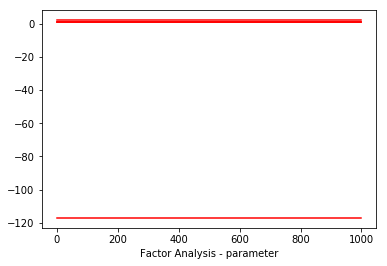

In [15]:
plt.plot(np.arange(0,len(output_logistic[:,0])),output_logistic[:,0], 'r-', alpha=1)
plt.xlabel('Logistic Regression - intercept')
plt.savefig('Data\\lr_intercept.png')

plt.plot(np.arange(0,len(output_logistic[:,1])),output_logistic[:,1], 'r-', alpha=1)
plt.xlabel('Logistic Regression - gender')
plt.savefig('Data\\lr_gender.png')

plt.plot(np.arange(0,len(output_logistic[:,10])),output_logistic[:,10], 'r-', alpha=1)
plt.xlabel('Logistic Regression - cancer type (one of them)')
plt.savefig('Data\\lr_cancertype.png')

plt.plot(np.arange(0,len(output_logistic[:,30])),output_logistic[:,30], 'r-', alpha=1)
plt.xlabel('Logistic Regression - k (one of them)')
plt.savefig('Data\\lr_k.png')

plt.plot(np.arange(0,len(output_factor_ln[:,2])),output_factor_ln[:,2], 'r-', alpha=1)
plt.xlabel('Factor Analysis - parameter')
plt.savefig('Data\\fa_1.png')

